In [1]:
#from mpl_toolkits import mplot3d
import pandas as pd
from numpy import array
import numpy as np
import h5py
import mplcursors
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,

    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "computer-modern-roman",

    "figure.dpi": 300,
    "savefig.dpi": 300,
})


CMAPS = plt.colormaps
CMAP = CMAPS['hsv']

h = 0.6774  # co-moving constant



dat = h5py.File('global_sample_data_snapshot_1200.hdf5')

# for x in dat.values():
#     try:
#         list(x)
#     except:
#         print(x)
#         raise
dat = pd.DataFrame((list(x) for x in dat.values() if x.shape != ()), index=(
    k for k in dat.keys() if dat[k].shape != ())).transpose()

dat['is_satellite'] = dat['groupID'] != -1

dat.loc[dat['is_satellite'] == False, 'plot_shape'] = 'o'
dat.loc[dat['is_satellite'], 'plot_shape'] = '^'

for mu in 'X', 'Y', 'Z':
    dat[f'{mu}_Mpc_ahf_cat'] = dat[f'{mu}c_ahf_cat'] / h

s_filt = dat['groupID'] != -1
h_filt = dat['groupID'] == -1

In [40]:
filt = dat['stars_mass_within_r50_stars'] < 1e9

m, b = np.polyfit(
    np.log(dat[filt]['stars_mass_within_r50_stars_ahf']),
    np.log(dat[filt]['r50_stars_ahf']),
    deg=1
)

x = np.linspace(1e6, 1e9, dat[filt].shape[0])

y = x**m * np.exp(b)

pwr_fit = x, y

dat['log_power_regression_r50'] = np.log(
    dat['r50_stars_ahf']) - (m * np.log(dat['stars_mass_within_r50_stars_ahf']) + b)


c:\Users\MkZee\anaconda3\envs\thesis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Proximity to Nearest Galaxy

In [34]:

def get_nearby(r_, delta_s):
    return (
        (r_[0] - delta_s < dat['Xc_ahf_cat']) & (dat['Xc_ahf_cat'] < r_[0] + delta_s) &
        (r_[1] - delta_s < dat['Yc_ahf_cat']) & (dat['Yc_ahf_cat'] < r_[1] + delta_s) &
        (r_[2] - delta_s < dat['Zc_ahf_cat']) & (dat['Zc_ahf_cat'] < r_[2] + delta_s)
    )
    
prox_to_nearest = np.zeros(dat.shape[0])
nearest_galaxy = np.zeros(dat.shape[0])

for i, row in enumerate(dat.itertuples()):
    r_ = [getattr(row, f'{mu}c_ahf_cat') for mu in ('X', 'Y', 'Z')]
    delta_s = 100
    while sum(res := get_nearby(r_, delta_s)) <2:
        delta_s += 100
    
    
    r_nearest = np.inf # initial value
    galaxy_nearest = -1
    for nearby in dat[res].itertuples():
        if nearby.galaxyID == row.galaxyID:
            continue
        
        r2_ = [getattr(nearby, f'{mu}c_ahf_cat') for mu in ('X', 'Y', 'Z')]
        
        r_squared = 0
        for s1, s2 in zip(r_, r2_):
            diff = abs(s1 - s2)  # coordinate delta
            # to account for the coordinate wrap-around (the universe repeats!)
            diff = diff if diff < 7500 else 15000 - diff
            r_squared += (diff)**2

        r = np.sqrt(r_squared)
        
        if r < r_nearest:
            r_nearest = r
            galaxy_nearest = nearby.galaxyID
    
    prox_to_nearest[i] = r_nearest
    nearest_galaxy[i] = galaxy_nearest
        
dat['prox_to_nearest'] = prox_to_nearest
dat['nearest_galaxy'] = nearest_galaxy


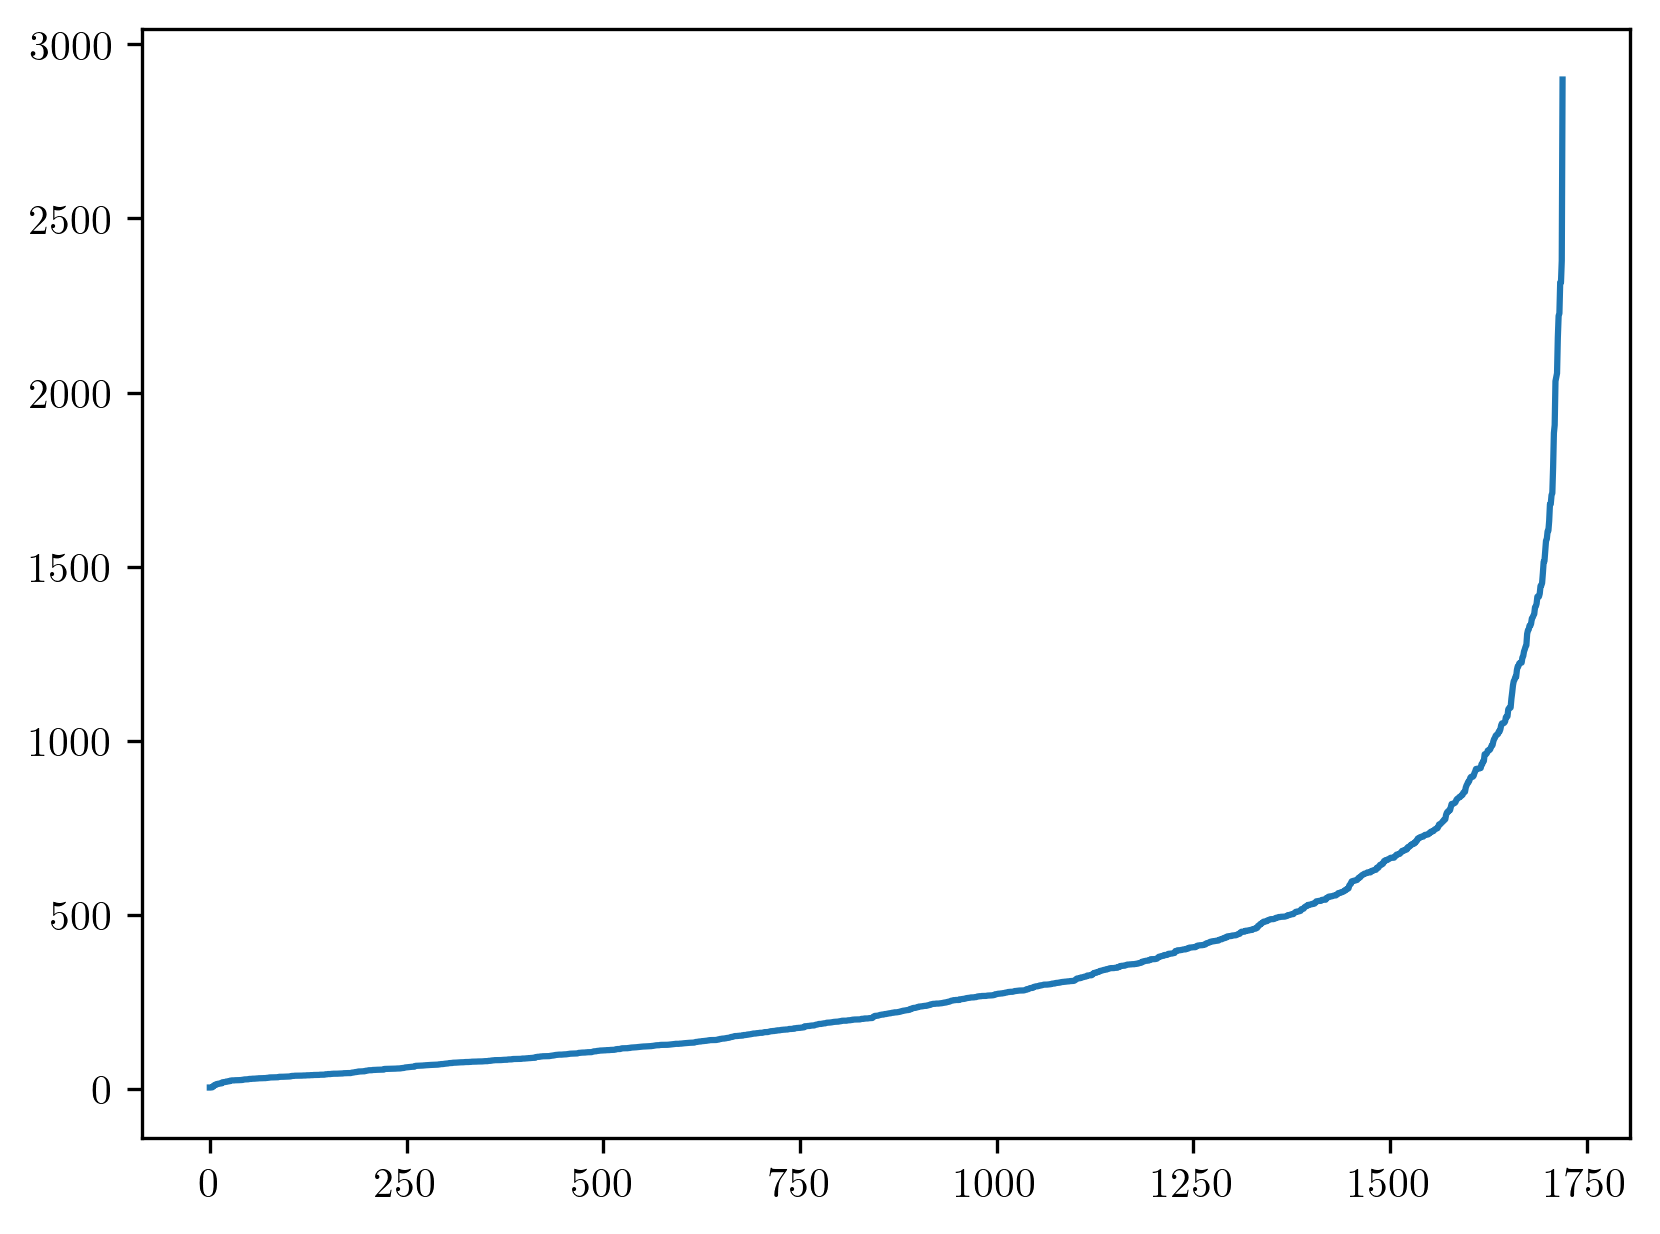

In [35]:
sorted = dat.sort_values('prox_to_nearest')

fig, ax = plt.subplots()

ax.plot(list(range(dat.shape[0])), sorted.prox_to_nearest)

In [37]:
fields = ('galaxyID', 'nearest_galaxy', 'prox_to_nearest', 'Xc_ahf_cat', 'Yc_ahf_cat', 'Zc_ahf_cat')
dat.loc[:, fields].query('galaxyID in (125.0, 0.0)')

,galaxyID,nearest_galaxy,prox_to_nearest,Xc_ahf_cat,Yc_ahf_cat,Zc_ahf_cat
0,0.0,125.0,26.547945,14711.058140,12986.948490,7614.448071
125,125.0,0.0,26.547945,14704.070091,13007.283211,7630.019188


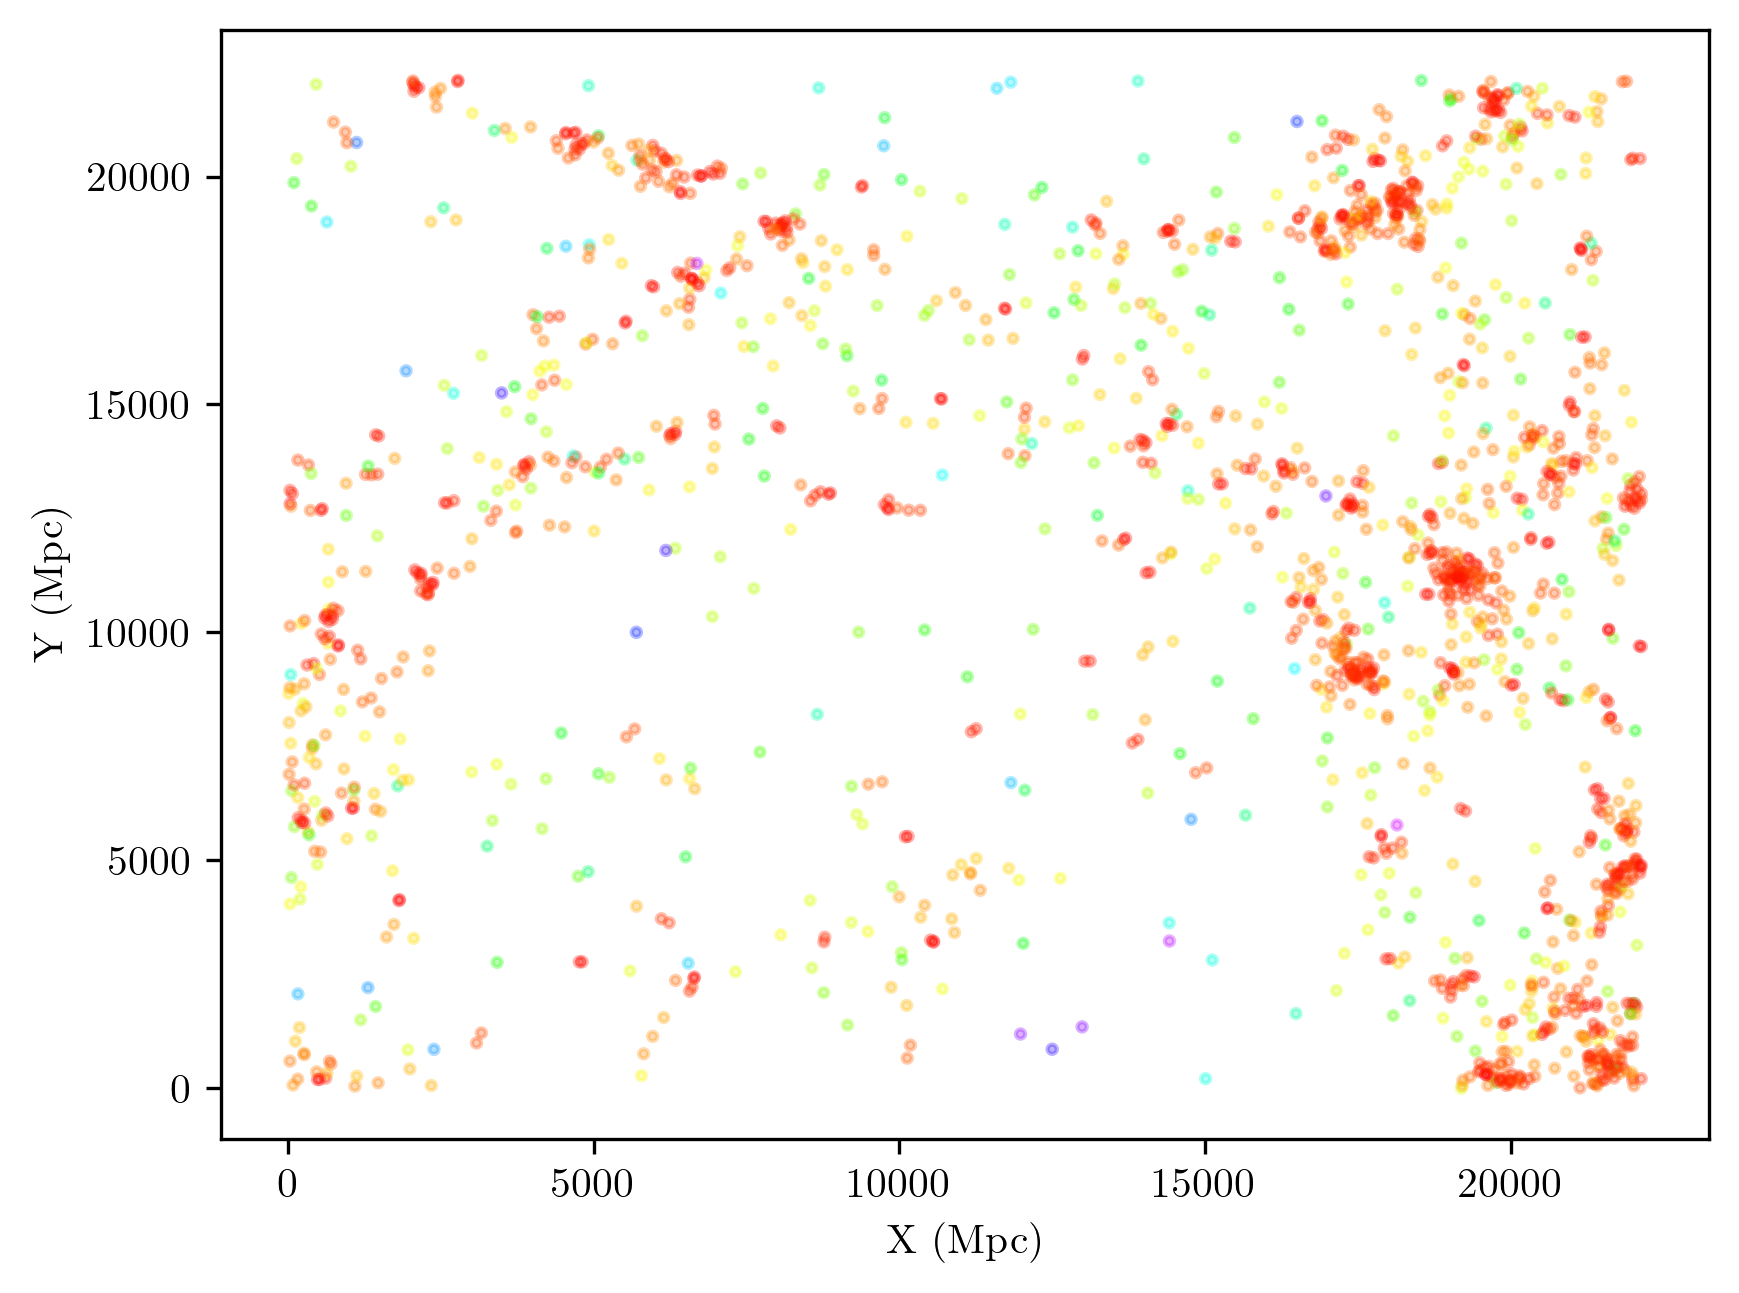

In [38]:
%matplotlib inline
fig, ax = plt.subplots()

x, y, z = dat['X_Mpc_ahf_cat'], dat['Y_Mpc_ahf_cat'], dat['Z_Mpc_ahf_cat']

_size = 5


_mappable = ax.scatter(
    y, z,
    alpha=0.3,
    s=_size,
    c=dat.prox_to_nearest,
    cmap=CMAP
)

# fig.colorbar(_mappable, label=r'$\beta$')
# ax.set_xlim((0 / h, 15000 / h))
# ax.set_ylim((0 / h, 10000 / h))
ax.set_xlabel('X (Mpc)')
ax.set_ylabel('Y (Mpc)')

# ax.legend(('Hosts', 'Satellites'))

fig.savefig('out.png')



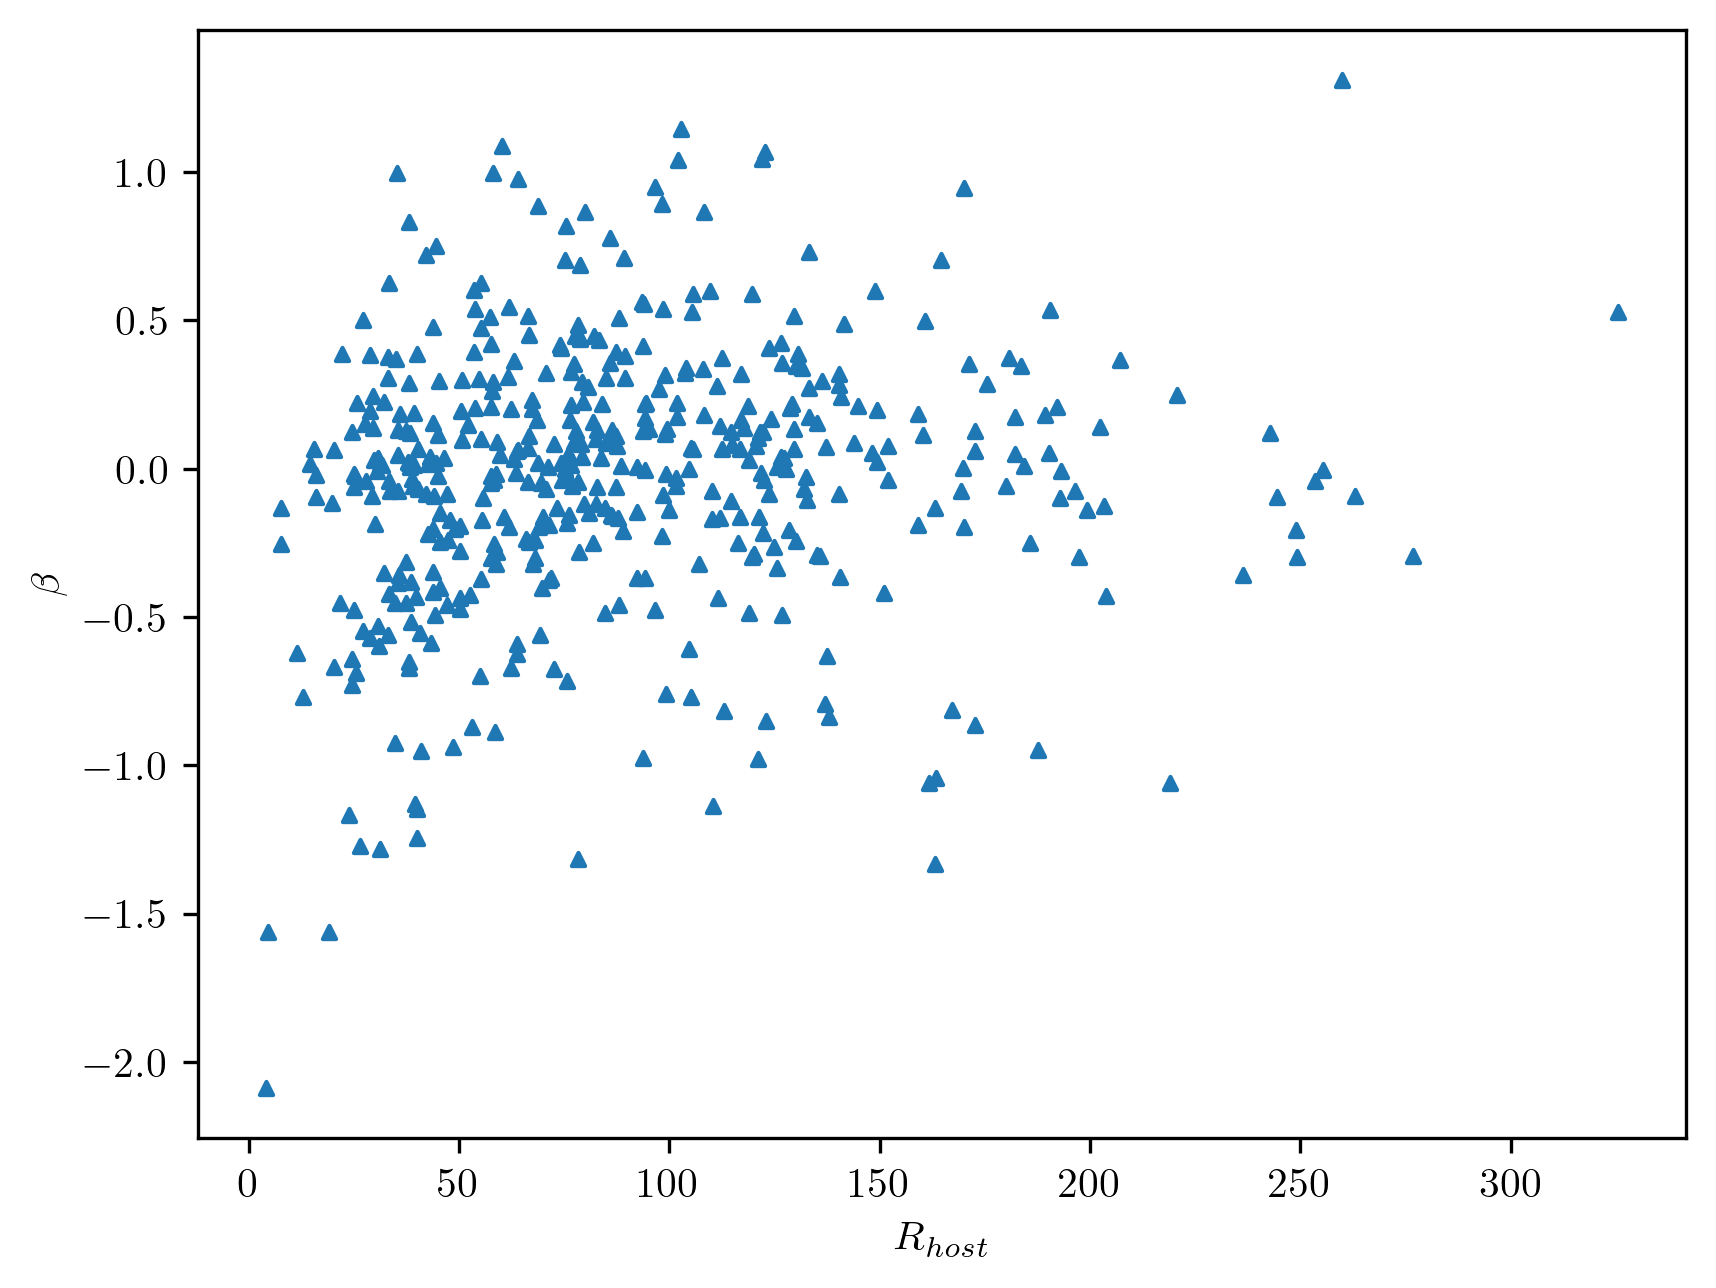

In [41]:
fig, ax = plt.subplots()

ax.scatter(
    dat[s_filt]['prox_to_nearest'],
    dat[s_filt]['log_power_regression_r50'],
    s=10,
    marker='^'
)

ax.set_xlabel(r'$R_{host}$')
ax.set_ylabel(r'$\beta$')

ax.set_label('Mass-Size Deviation and $R_{host}$')